# Collaborative Filtering vs Content based items vs hybrid systems


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

In [2]:
import pandas as pd


"""
From: http://files.grouplens.org/datasets/movielens/ml-100k-README.txt
u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   """

all_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), 
                          sep='\t', 
                          names=["user_id", "item_id", "rating", "timestamp"])

# one line corresponds to one rating per user per movie.

all_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
names = ["name", "date", "genre", "url"]
names += ["feat_" + str(x) for x in range(19)]


"""
From: http://files.grouplens.org/datasets/movielens/ml-100k-README.txt
u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.
"""

items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|', encoding='latin-1',
                    names=names)

# some dates are Nan so we set a default value.
# it's not important for our study.
items.fillna(value="01-Jan-1997", inplace=True) 
items.head()

,name,date,genre,url,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,...,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18
1,Toy Story (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,01-Jan-1997,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# the dataset is a bit skewed towards high ratings. The average is around 3.53 with a standard deviation of 1.12.

all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [5]:
print('Number of users:', len(all_ratings['user_id'].unique()))

Number of users: 943


In [6]:
print('Number of movies:', len(all_ratings['item_id'].unique()))

Number of movies: 1682


In [7]:
max_user_id = all_ratings['user_id'].max()
max_item_id = all_ratings['item_id'].max()

In [8]:
# we split the dataset into a training and a testing set.

from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']

In [9]:
# we have 80 000 samples in the training set.
user_id_train.shape, item_id_train.shape, rating_train.shape

((80000,), (80000,), (80000,))

In [10]:
# we have 20 000 samples in the testing set.
user_id_test.shape, item_id_test.shape, rating_test.shape

((20000,), (20000,), (20000,))

# Supervised Ranking prediction

- Based on a pair (user_id, item_id), we want to be able to predict the rating.
- An example is: What would the rating John Appleseed (user id = 404) give to Toy Story 3 (item id = 666)? Would it be 3.5? 4.5?

## Collaborative Filtering

- Collaborative filtering does not use the features of the items to predict the rating. It only uses the similarity between the different users to make a prediction.
- Let's see what we can get!

In [11]:
# keras headers. Make sure you use the TensorFlow back

from keras import layers
from keras.layers import Input, Embedding, Flatten, Dense, Dropout
from keras.models import Model

Using TensorFlow backend.


In [12]:
# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 11 # 2^11 = 2048. So we could index each movie or user with this embedding.
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

# y = merge([user_vecs, item_vecs], mode='dot', output_shape=(1,))
y = layers.dot([user_vecs, item_vecs], axes=1)

model = Model(inputs=[user_id_input, item_id_input], outputs=[y])
model.compile(optimizer='adam', loss='mae')

In [13]:
# Useful for debugging the output shape of model
initial_train_preds = model.predict([user_id_train, item_id_train]).squeeze()
print(initial_train_preds.shape)

(80000,)


In [14]:
# just to show you how random the score are! Half are negative when scores are defined positive.
pd.DataFrame(initial_train_preds).describe()

,0
count,80000.000000
mean,-0.000013
std,0.002803
min,-0.011752
25%,-0.001894
50%,-0.000022
75%,0.001863
max,0.011778


In [15]:
# Throughout the study we're going to use the MAE error. 
# It's pretty easy to understand because it's the mean absolute error.
# For example, if the true score is 3.5 and we predict 2.1, the error is 3.5 - 2.1 = 1.4
# The MSE is a bit harder to understand.

from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))

Random init MAE: 3.531


In [16]:
# Let's start the training.

history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=20, validation_split=0.1,
                    shuffle=True, verbose=2)

Train on 72000 samples, validate on 8000 samples
Epoch 1/20
1s - loss: 3.2745 - val_loss: 2.3261
Epoch 2/20
1s - loss: 1.4207 - val_loss: 1.0231
Epoch 3/20
1s - loss: 0.8965 - val_loss: 0.8479
Epoch 4/20
1s - loss: 0.7881 - val_loss: 0.7959
Epoch 5/20
1s - loss: 0.7490 - val_loss: 0.7752
Epoch 6/20
1s - loss: 0.7301 - val_loss: 0.7660
Epoch 7/20
1s - loss: 0.7190 - val_loss: 0.7582
Epoch 8/20
1s - loss: 0.7114 - val_loss: 0.7551
Epoch 9/20
1s - loss: 0.7050 - val_loss: 0.7540
Epoch 10/20
1s - loss: 0.7002 - val_loss: 0.7518
Epoch 11/20
1s - loss: 0.6964 - val_loss: 0.7492
Epoch 12/20
1s - loss: 0.6924 - val_loss: 0.7478
Epoch 13/20
1s - loss: 0.6896 - val_loss: 0.7474
Epoch 14/20
1s - loss: 0.6865 - val_loss: 0.7473
Epoch 15/20
1s - loss: 0.6840 - val_loss: 0.7452
Epoch 16/20
1s - loss: 0.6811 - val_loss: 0.7451
Epoch 17/20
1s - loss: 0.6786 - val_loss: 0.7439
Epoch 18/20
1s - loss: 0.6762 - val_loss: 0.7411
Epoch 19/20
1s - loss: 0.6732 - val_loss: 0.7415
Epoch 20/20
1s - loss: 0.6707

In [17]:
train_preds = model.predict([user_id_train, item_id_train]).squeeze()
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

test_preds = model.predict([user_id_test, item_id_test]).squeeze()
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final train MAE: 0.664
Final test MAE: 0.735


In [18]:
# Let's now consider a bigger model.

In [19]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 11
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = layers.concatenate([user_vecs, item_vecs])
## Error 1: Dropout was too high, preventing any training
input_vecs = Dropout(0.5)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)

## Error 2: output dimension was 2 where we predict only 1-d rating
## Error 3: tanh activation squashes the outputs between -1 and 1
## when we want to predict values between 1 and 5
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=[y])
## Error 4: A binary crossentropy loss is only useful for binary
## classification, while we are in regression (use mse or mae)
model.compile(optimizer='adam', loss='mae')

In [20]:
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=20, validation_split=0.1,
                    shuffle=True, verbose=2)

Train on 72000 samples, validate on 8000 samples
Epoch 1/20
2s - loss: 1.0474 - val_loss: 0.7646
Epoch 2/20
2s - loss: 0.7578 - val_loss: 0.7552
Epoch 3/20
2s - loss: 0.7443 - val_loss: 0.7515
Epoch 4/20
2s - loss: 0.7368 - val_loss: 0.7490
Epoch 5/20
2s - loss: 0.7322 - val_loss: 0.7455
Epoch 6/20
2s - loss: 0.7278 - val_loss: 0.7462
Epoch 7/20
2s - loss: 0.7239 - val_loss: 0.7454
Epoch 8/20
2s - loss: 0.7246 - val_loss: 0.7448
Epoch 9/20
2s - loss: 0.7197 - val_loss: 0.7435
Epoch 10/20
2s - loss: 0.7177 - val_loss: 0.7458
Epoch 11/20
2s - loss: 0.7145 - val_loss: 0.7390
Epoch 12/20
2s - loss: 0.7122 - val_loss: 0.7391
Epoch 13/20
2s - loss: 0.7121 - val_loss: 0.7438
Epoch 14/20
2s - loss: 0.7096 - val_loss: 0.7347
Epoch 15/20
2s - loss: 0.7054 - val_loss: 0.7353
Epoch 16/20
2s - loss: 0.7047 - val_loss: 0.7294
Epoch 17/20
2s - loss: 0.7023 - val_loss: 0.7300
Epoch 18/20
2s - loss: 0.7009 - val_loss: 0.7293
Epoch 19/20
2s - loss: 0.7015 - val_loss: 0.7316
Epoch 20/20
2s - loss: 0.6998

In [21]:
train_preds = model.predict([user_id_train, item_id_train]).squeeze()
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

test_preds = model.predict([user_id_test, item_id_test]).squeeze()
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final train MAE: 0.676
Final test MAE: 0.716


## Item Content Based Filtering

- Now we're going to use the information of the items to predict the rating. 
- We forget about the user.

In [22]:
# Some pre processing here.

# transform the date (string) into an int representing the release year
parsed_dates = [int(film_date[-4:])
                for film_date in items["date"].tolist()]

items['parsed_date'] = pd.Series(parsed_dates, index=items.index)
max_date = max(items['parsed_date'])
min_date = min(items['parsed_date'])

from sklearn.preprocessing import scale

items['scaled_date'] = scale(items['parsed_date'].astype('float64'))
item_meta_train = items["scaled_date"][item_id_train]
item_meta_test = items["scaled_date"][item_id_test]

len(item_meta_train), len(item_meta_test)

(80000, 20000)

In [23]:

# For each sample we input the integer identifiers
# of a single user and a single item
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[1], name='meta_item')

embedding_size = 32
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)
item_vecs = Flatten()(item_embedding)

input_vecs = layers.concatenate([item_vecs, meta_input])

x = Dense(64, activation='relu')(input_vecs)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(input_vecs)
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input, meta_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

In [24]:
history = model.fit([user_id_train, item_id_train, item_meta_train], rating_train,
                    batch_size=64, epochs=20, validation_split=0.1,
                    shuffle=True, verbose=2)

Train on 72000 samples, validate on 8000 samples
Epoch 1/20
2s - loss: 1.0483 - val_loss: 0.8212
Epoch 2/20
1s - loss: 0.7946 - val_loss: 0.8146
Epoch 3/20
1s - loss: 0.7850 - val_loss: 0.8115
Epoch 4/20
1s - loss: 0.7802 - val_loss: 0.8078
Epoch 5/20
1s - loss: 0.7769 - val_loss: 0.8061
Epoch 6/20
2s - loss: 0.7748 - val_loss: 0.8087
Epoch 7/20
2s - loss: 0.7732 - val_loss: 0.8071
Epoch 8/20
2s - loss: 0.7718 - val_loss: 0.8047
Epoch 9/20
2s - loss: 0.7707 - val_loss: 0.8055
Epoch 10/20
2s - loss: 0.7694 - val_loss: 0.8062
Epoch 11/20
2s - loss: 0.7688 - val_loss: 0.8053
Epoch 12/20
2s - loss: 0.7676 - val_loss: 0.8045
Epoch 13/20
2s - loss: 0.7669 - val_loss: 0.8036
Epoch 14/20
2s - loss: 0.7669 - val_loss: 0.8066
Epoch 15/20
1s - loss: 0.7661 - val_loss: 0.8030
Epoch 16/20
2s - loss: 0.7655 - val_loss: 0.8043
Epoch 17/20
2s - loss: 0.7652 - val_loss: 0.8038
Epoch 18/20
2s - loss: 0.7651 - val_loss: 0.8043
Epoch 19/20
2s - loss: 0.7645 - val_loss: 0.8026
Epoch 20/20
2s - loss: 0.7642

In [25]:
# It does not work well. The error is much higher when the user_id is not here. 
# It means that the user is important.

train_preds = model.predict([user_id_train, item_id_train, item_meta_train]).squeeze()
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

test_preds = model.predict([user_id_test, item_id_test, item_meta_test]).squeeze()
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final train MAE: 0.764
Final test MAE: 0.791


# Hybrid Systems

- Let's not combine the two: Collaborative Filtering and Content Based Items
- And see if it helps improve the loss on the test set, when computing the ratings!

In [26]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[1], name='meta_item')

embedding_size = 11
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = layers.concatenate([user_vecs, item_vecs, meta_input])
input_vecs = Dropout(0.5)(input_vecs)

# Final test MAE: 0.712
x = Dense(64, activation='relu')(input_vecs)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
y = Dense(1)(x)


model = Model(inputs=[user_id_input, item_id_input, meta_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

In [27]:
history = model.fit([user_id_train, item_id_train, item_meta_train], rating_train,
                    batch_size=64, epochs=20, validation_split=0.1,
                    shuffle=True, verbose=2)

Train on 72000 samples, validate on 8000 samples
Epoch 1/20
3s - loss: 1.0204 - val_loss: 0.7789
Epoch 2/20
3s - loss: 0.7934 - val_loss: 0.7671
Epoch 3/20
3s - loss: 0.7621 - val_loss: 0.7480
Epoch 4/20
3s - loss: 0.7403 - val_loss: 0.7438
Epoch 5/20
2s - loss: 0.7294 - val_loss: 0.7463
Epoch 6/20
3s - loss: 0.7225 - val_loss: 0.7385
Epoch 7/20
3s - loss: 0.7202 - val_loss: 0.7352
Epoch 8/20
3s - loss: 0.7152 - val_loss: 0.7410
Epoch 9/20
3s - loss: 0.7122 - val_loss: 0.7354
Epoch 10/20
3s - loss: 0.7139 - val_loss: 0.7386
Epoch 11/20
3s - loss: 0.7093 - val_loss: 0.7342
Epoch 12/20
3s - loss: 0.7075 - val_loss: 0.7327
Epoch 13/20
2s - loss: 0.7074 - val_loss: 0.7358
Epoch 14/20
2s - loss: 0.7082 - val_loss: 0.7329
Epoch 15/20
3s - loss: 0.7066 - val_loss: 0.7330
Epoch 16/20
2s - loss: 0.7055 - val_loss: 0.7313
Epoch 17/20
2s - loss: 0.7026 - val_loss: 0.7302
Epoch 18/20
3s - loss: 0.7009 - val_loss: 0.7344
Epoch 19/20
3s - loss: 0.7026 - val_loss: 0.7268
Epoch 20/20
2s - loss: 0.7002

In [28]:
train_preds = model.predict([user_id_train, item_id_train, item_meta_train]).squeeze()
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

test_preds = model.predict([user_id_test, item_id_test, item_meta_test]).squeeze()
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final train MAE: 0.682
Final test MAE: 0.715


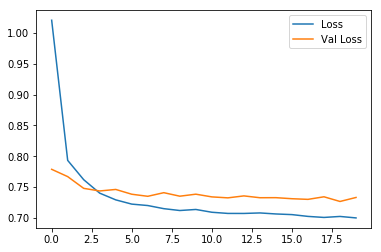

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
# The values you see here are the recorded training_loss, and validation_loss after each epoch.
# The first value correspond to the losses after the first epoch.
# The convergence is quick.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.legend(['Loss', 'Val Loss'])

# Movie Recommendation

- Finally let's see how predicting ratings helps us recommend nice movies to John!

In [29]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_movies = list(all_ratings[all_ratings["user_id"] == user_id]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    print("user " + str(user_id) + " has seen " + str(len(seen_movies)) + " movies. " +
          "Computing ratings for " + str(len(item_ids)) + " other movies")

    item_ids = np.array(item_ids)
    user = np.zeros_like(item_ids)
    user[:] = user_id
    items_meta = items["scaled_date"][item_ids].values

    rating_preds = model.predict([user, item_ids, items_meta])

    item_ids = np.argsort(rating_preds[:, 0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["name"][movie], rating_preds[movie][0]) for movie in rec_items]

In [42]:
for recommended_movie in recommend(404):
    print('-', recommended_movie[0], '- predicted score:', '%.2f' % recommended_movie[1])

user 404 has seen 44 movies. Computing ratings for 1637 other movies
- Miracle on 34th Street (1994) - predicted score: 4.58
- Face/Off (1997) - predicted score: 4.57
- Assassins (1995) - predicted score: 4.49
- Manon of the Spring (Manon des sources) (1986) - predicted score: 4.48
- Cold Comfort Farm (1995) - predicted score: 4.47
- Jaws 3-D (1983) - predicted score: 4.45
- Withnail and I (1987) - predicted score: 4.45
- Seven (Se7en) (1995) - predicted score: 4.43
- Hoop Dreams (1994) - predicted score: 4.42
- Outlaw, The (1943) - predicted score: 4.41
